## Criminality Rate of Neighborhoods in Barcelona - Get Settled

In [2]:
#Importing Libraries
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
plt.ion()
import seaborn as sns
sns.set()
from googletrans import Translator

In [3]:
# Reading the files
incidents_2015 = pd.read_excel('2015_incidents_gestionats_gub.xlsx')
incidents_2016 = pd.read_excel('2016_incidents_gestionats_gub.xlsx')
incidents_2017 = pd.read_csv('2017_incidents_gestionats_gub.csv')
incidents_2018 = pd.read_csv('2018_incidents_gestionats_gub.csv')

In [4]:
#Merging all incidents from 2015 - 2018 into one dataframe
for incidents in (incidents_2015, incidents_2016, incidents_2017,incidents_2018):
    incidents =  incidents.append(incidents, ignore_index=True)

### We see that the dataset is in Catalan. Our first job is to convert it into English. We found that upon directly converting to English, the translator() is not so effcient. Thus, we first converted Catalan to Spanish and then to English.

In [8]:
translator = Translator()

In [9]:
# Translating columns to English
english_columns = [translator.translate(col).text.replace(' ', '_').lower() for col in incidents.columns]
incidents.columns = english_columns
incidents.columns = ['incident_code','description_incident','code_district','name_district','code_neighbourhood',
                    'name_neighbourhood','year_of_incident','month_year','month_name','number_incidents_gub']
incidents=incidents.set_index('incident_code')
incidents.head()

In [13]:
# There are 93 unique incidents reported from 2015 - 2018
incidents.description_incident.unique().size

93

In [14]:
# Eliminating the empty spaces in the description incident column
incidents.description_incident = incidents.description_incident.str.strip()

In [15]:
# Translating the incident description from Catalan to Spanish and finally to English
translate_descriptions = [translator.translate(value, dest='es').text for value in incidents.description_incident.value_counts().index]
translate_descriptions = [translator.translate(value).text for value in translate_descriptions]
translate_descriptions;

In [17]:
#Creating a dictionary of Catalan incident descriptions to their corresponding english translations
cat_to_en = dict(zip(incidents.description_incident.value_counts().index.tolist(), translate_descriptions))
cat_to_en;

In [19]:
rev_multidict = {}
for key, value in cat_to_en.items():
    rev_multidict.setdefault(value, set()).add(key)
len(rev_multidict)

92

In [22]:
#Mapping incident translations back to the incident dataframe
incidents.description_incident = incidents.description_incident.map(cat_to_en)
incidents.head();

In [24]:
#Translating months to English
translate_month = [translator.translate(value, dest='es').text for value in incidents.month_name.value_counts().index]
translate_month = [translator.translate(value).text for value in translate_month]
translate_month[3] = 'May'

In [26]:
#Mapping month translations back to the incident dataframe
cat_to_en1 = dict(zip(incidents.month_name.value_counts().index.tolist(), translate_month))
incidents.month_name = incidents.month_name.map(cat_to_en1)

## Feature Engineering: Given some incidents represent a higher risk than others, we will create categories that will group incidents into three categories (High, Medium, Low)

### First we group incidents with similar descriptions that will allow us to process less incidents in the forthcoming stages.

In [217]:
# Changing the descriptions of CONFLICTS IN LOCAL & INFRACTIONS IN LOCAL to LOCAL INCIDENTS 
incidents[(incidents.description_incident == 'CONFLICTS IN LOCAL') 
          | (incidents.description_incident == 'INFRACTIONS IN LOCAL')].description_incident = 'LOCAL INCIDENTS'

In [218]:
# Changing the description of of FIGHTS to ATTACKS
incidents.loc[(incidents.description_incident == 'FIGHTS')].description_incident = 'ATTACKS'

In [219]:
# Changing ACTS AGAINST PRIVATE PROPERTY, ACTS AGAINST PUBLIC PROPERTY & ACTS AGAINST PROPERTY to VANDALISM.
incidents.loc[(incidents.description_incident == 'ACTS AGAINST PRIVATE PROPERTY') 
              | (incidents.description_incident == 'ACTS AGAINST PUBLIC PROPERTY') 
              | (incidents.description_incident == 'ACTS AGAINST THE PROPERTY')].description_incident = 'VANDALISM'

### We have manually defined 3 ranges: high, medium and low depending on the severity of the incidents based on our intuition. We read the file "Project_Criminalityfeature.xlsx" where we have mapped these incidents to its corresponding categories

In [264]:
crime_df = pd.read_excel('Project_Criminalityfeature.xlsx')
crime_df

,high,medium,low
0,FIRES,CRIMES AGAINST PUBLIC ORDER,PARKING VIOLATIONS
1,EXPLOSIONS,INCIDENTS WITH PRISONERS AND DETAINEES,OTHER INCIDENTS WITH ANIMALS
2,DANGEROUS MATTERS,URBAN TRIBES,AGAINST THE RIGHTS OF WORKERS
3,TRAFFIC ACCIDENTS WITH PERILLOSSES MATTERS,LOCAL INCIDENTS,HUNTING / FISHING / FLORA / FAUNA
4,POLICE SURVEILLANCE,TRAFFIC ACCIDENTS WITH WOUNDED,custody
5,ACTIVITY WITH PRISONERS,INJURED TRAFFIC ACCIDENTS,TRAFFIC CONTROLS
6,INFRACTIONS OF FOREIGNERS,INCIDENTS WITH TRAFFIC HAZARD,TRANSFERS OF VEHICLES WITHOUT INFRINGEMENT
7,DOMESTIC VIOLENCE,INCIDENTS WITH ROAD AFFECTION,MOVEMENT INFRACTIONS (VEHICLES)
8,neighborhood coexistence,PEDDLING,ANIMALS / DANGEROUS INSECTS
9,ATTACKS,ANNOYING ACTIVITIES IN PUBLIC SPACES,"OTHER INTERVENTIONS OF P, ADMINISTRATIVE"


In [265]:
#Adding a new Column crime_risk to our main dataframe that defines severity level.
incidents['crime_risk'] = ''

In [285]:
high = crime_df.high.dropna()
high.to_frame()

,high
0,FIRES
1,EXPLOSIONS
2,DANGEROUS MATTERS
3,TRAFFIC ACCIDENTS WITH PERILLOSSES MATTERS
4,POLICE SURVEILLANCE
5,ACTIVITY WITH PRISONERS
6,INFRACTIONS OF FOREIGNERS
7,DOMESTIC VIOLENCE
8,neighborhood coexistence
9,ATTACKS


In [283]:
# Setting crime_risk column to high for corresponding incidents 
incidents.loc[(incidents['description_incident'] == 'FIRES') |
              (incidents['description_incident'] == 'EXPLOSIONS') |
              (incidents['description_incident'] == 'DANGEROUS MATTERS') |
              (incidents['description_incident'] == 'TRAFFIC ACCIDENTS WITH PERILLOSSES MATTERS') |
              (incidents['description_incident'] == 'POLICE SURVEILLANCE') |
              (incidents['description_incident'] == 'ACTIVITY WITH PRISONERS') |
              (incidents['description_incident'] == 'INFRACTIONS OF FOREIGNERS') |
              (incidents['description_incident'] == 'DOMESTIC VIOLENCE') |
              (incidents['description_incident'] == 'neighborhood coexistence') |
              (incidents['description_incident'] == 'ATTACKS') |
              (incidents['description_incident'] == 'NARCOTICS / psychotropic') |
              (incidents['description_incident'] == 'AGAINST SEXUAL FREEDOM') |
              (incidents['description_incident'] == 'MANIFESTATIONS / CONCENTRATIONS') |
              (incidents['description_incident'] == 'FIRE / FIRE ALARMS') |
              (incidents['description_incident'] == 'VANDALISM') |
              (incidents['description_incident'] == 'PUBLIC SERVICE FAILURES'), 'crime_risk'] = 'high'

In [284]:
medium = crime_df.medium.dropna()
medium.to_frame()

,medium
0,CRIMES AGAINST PUBLIC ORDER
1,INCIDENTS WITH PRISONERS AND DETAINEES
2,URBAN TRIBES
3,LOCAL INCIDENTS
4,TRAFFIC ACCIDENTS WITH WOUNDED
5,INJURED TRAFFIC ACCIDENTS
6,INCIDENTS WITH TRAFFIC HAZARD
7,INCIDENTS WITH ROAD AFFECTION
8,PEDDLING
9,ANNOYING ACTIVITIES IN PUBLIC SPACES


In [286]:
# Setting crime_risk column to medium for corresponding incidents 
incidents.loc[ (incidents['description_incident'] == 'CRIMES AGAINST PUBLIC ORDER') |
              (incidents['description_incident'] == 'INCIDENTS WITH PRISONERS AND DETAINEES') |
              (incidents['description_incident'] == 'URBAN TRIBES') |
              (incidents['description_incident'] == 'LOCAL INCIDENTS') |
              (incidents['description_incident'] == 'VANDALISM') |
              (incidents['description_incident'] == 'TRAFFIC ACCIDENTS WITH WOUNDED') |
              (incidents['description_incident'] == 'INJURED TRAFFIC ACCIDENTS') |
              (incidents['description_incident'] == 'INCIDENTS WITH TRAFFIC HAZARD') |
              (incidents['description_incident'] == 'INCIDENTS WITH ROAD AFFECTION') |
              (incidents['description_incident'] == 'PEDDLING') |
              (incidents['description_incident'] == 'ANNOYING ACTIVITIES IN PUBLIC SPACES') |
              (incidents['description_incident'] == 'WASTE DISPOSAL') |
              (incidents['description_incident'] == 'FOOD INCIDENTS') |
              (incidents['description_incident'] == 'SALVATIONS') |
              (incidents['description_incident'] == 'SHOWS IN PUBLIC SPACES') |
              (incidents['description_incident'] == 'FOGUERES / BARBECUES') |
              (incidents['description_incident'] == 'DISCOMFORTS BY GENERATORS') |
              (incidents['description_incident'] == 'ILLICIT OCCUPATIONS') |
              (incidents['description_incident'] == 'TEMPORARY TRAFFIC RESTRICTIONS') |
              (incidents['description_incident'] == 'OCCUPATIONS OF PUBLIC SPACES') |
              (incidents['description_incident'] == 'Strong winds') |
              (incidents['description_incident'] == 'SNOW AND ICE') |
              (incidents['description_incident'] == 'TORRENTIAL RAIN') |
              (incidents['description_incident'] == 'WORKS / WORKS IN PUBLIC SPACES') |
              (incidents['description_incident'] == 'FOOD CRIMES') , 'crime_risk'] = 'medium'

In [287]:
low = crime_df.low.dropna()
low.to_frame()

,low
0,PARKING VIOLATIONS
1,OTHER INCIDENTS WITH ANIMALS
2,AGAINST THE RIGHTS OF WORKERS
3,HUNTING / FISHING / FLORA / FAUNA
4,custody
5,TRAFFIC CONTROLS
6,TRANSFERS OF VEHICLES WITHOUT INFRINGEMENT
7,MOVEMENT INFRACTIONS (VEHICLES)
8,ANIMALS / DANGEROUS INSECTS
9,"OTHER INTERVENTIONS OF P, ADMINISTRATIVE"


In [288]:
# Setting crime_risk column to low for corresponding incidents 
incidents.loc[(incidents['description_incident'] == 'PARKING VIOLATIONS') |
              (incidents['description_incident'] == 'OTHER INCIDENTS WITH ANIMALS') |
              (incidents['description_incident'] == 'AGAINST THE RIGHTS OF WORKERS') |
              (incidents['description_incident'] == 'HUNTING / FISHING / FLORA / FAUNA') |
              (incidents['description_incident'] == 'custody') |
              (incidents['description_incident'] == 'TRAFFIC CONTROLS') |
              (incidents['description_incident'] == 'TRANSFERS OF VEHICLES WITHOUT INFRINGEMENT') |
              (incidents['description_incident'] == 'MOVEMENT INFRACTIONS (VEHICLES)') |
              (incidents['description_incident'] == 'ANIMALS / DANGEROUS INSECTS') |
              (incidents['description_incident'] == 'OTHER INTERVENTIONS OF P, ADMINISTRATIVE') |
              (incidents['description_incident'] == 'ACCIDENT COMING FROM CME') |
              (incidents['description_incident'] == 'CONDUCTIONS AND ACCOMPANIMENTS') |
              (incidents['description_incident'] == 'INMOVILIZACIONES / DESIMMOBILITZACIONS') |
              (incidents['description_incident'] == 'EDUCATIONAL SCOPE') |
              (incidents['description_incident'] == 'PUBLIC TRANSPORT') |
              (incidents['description_incident'] == 'REFORM') |
              (incidents['description_incident'] == 'OFFICIAL BUILDINGS') |
              (incidents['description_incident'] == 'EMERGENCY COMMUNICATIONS') |
              (incidents['description_incident'] == 'TECHNICAL FAILURE') |
              (incidents['description_incident'] == 'ACCIDENT PASSWORD SEM') |
              (incidents['description_incident'] == 'TESTS OF THE SYSTEM') |
              (incidents['description_incident'] == 'TECHNICAL ASSISTANCE') |
              (incidents['description_incident'] == 'ASSISTANCE TO PEOPLE IN PUBLIC SPACES') |
              (incidents['description_incident'] == 'ASSISTANCE MENTAL ILLNESS') |
              (incidents['description_incident'] == 'BEACH ASSISTANCE') |
              (incidents['description_incident'] == 'BASIC SUPPLIES') |
              (incidents['description_incident'] == 'OTHER ACTIONS OF S, C,') |
              (incidents['description_incident'] == 'INFRACTIONS IN VADOS AND RESERVATIONS') |
              (incidents['description_incident'] == 'COMPANY ANIMALS') |
              (incidents['description_incident'] == 'COLLABORATION WITH OTHER SERVICES') |
              (incidents['description_incident'] == 'SUPPORTS') |
              (incidents['description_incident'] == 'AUTOMATED SIGNALS') |
              (incidents['description_incident'] == 'SCOPE OF PROTECTION OF THE MINOR') |
              (incidents['description_incident'] == 'ASSISTANCE DRIVERS IN V, P') |
              (incidents['description_incident'] == 'MUNICIPAL SERVICES MALFUNCTIONS') |
              (incidents['description_incident'] == 'INSPECTIONS / CONTROLS IN LOCAL') |
              (incidents['description_incident'] == 'COL·LBORACIÓ WITH JUDICIAL / POLICE AUTHORITY') |
              (incidents['description_incident'] == 'CLAIMS IN BUILDINGS') |
              (incidents['description_incident'] == 'ACCIDENT RECEIPT BY 080 (Recode)') |
              (incidents['description_incident'] == 'NON-AUTOMATED SIGNALS') |
              (incidents['description_incident'] == 'OTHER ACTIONS IN THE ENVIRONMENT') |
              (incidents['description_incident'] == 'ASSISTANCE TO PEOPLE IN BUILDING') |
            (incidents['description_incident'] == 'WITHOUT IDENTIFYING'), 'crime_risk'] = 'low'

In [293]:
# Creating new dataframe with neighborhoods and sum of incidents per crime_risk category
incidents_considered = incidents[(incidents.crime_risk == 'high') 
                                 | (incidents.crime_risk == 'medium') 
                                 | (incidents.crime_risk == 'low')]
safety_df = pd.DataFrame(pd.crosstab(incidents_considered.name_neighbourhood,incidents_considered.crime_risk))
safety_df.head()

crime_risk,high,low,medium
name_neighbourhood,,,
Baró de Viver,80,172,146
Can Baró,132,300,180
Can Peguera,106,218,96
Canyelles,112,258,188
Ciutat Meridiana,182,322,176


In [294]:
# Assigning bigger weights for incidents in high and medium categories, this will give is a preliminary score
safety_df['tot_score'] = (safety_df['high'] * 100) + (safety_df['medium'] * 10) + (safety_df['low'] * 1)

In [296]:
#Reading the population per neighborhood file which will serve to standarize the score on population density
population_df = pd.read_csv("2018_padro_ocupacio_mitjana.csv")
population_df.rename(columns={'Nom_Barri':'name_neighbourhood','Població':'population',
                             'Domicilis':'domicile',
                              'Ocupació mitjana (persones per domicili)':'average population per domicile'},inplace=True)
population_df = population_df.drop(['Any','domicile','average population per domicile'],axis=1)
population_df = population_df.drop(columns = ['Codi_Districte', 'Codi_Barri'])
population_df;

In [248]:
#Reading the surface area per neighborhood file, we can also use this to standarize the crime rate per neighborhood 
surface_area =  pd.read_csv("2017_superficie.csv")
surface_area.rename(columns={'Nom_Barri':'name_neighbourhood','Superfície (ha)':'surface_area (ha)',
                             'Codi_Barri':'code_neighbourhood', 'Nom_Districte':'name_district',
                              'Codi_Districte':'code_district'},inplace=True)
surface_area= surface_area.drop(columns = ['name_district', 'code_neighbourhood', 'code_district', 'Any'])

In [298]:
#Joining population and surface area to the crime rate dataframe
merged_df = safety_df.merge(population_df,on='name_neighbourhood',how = 'left')
merged_df = merged_df.merge(surface_area,on='name_neighbourhood',how = 'right')
merged_df.head()

,name_neighbourhood,high,low,medium,tot_score,Nom_Districte,population,surface_area (ha)
0,Baró de Viver,80.0,172.0,146.0,9632.0,Sant Andreu,2535.0,23.0
1,Can Baró,132.0,300.0,180.0,15300.0,Horta-Guinardó,9071.0,38.4
2,Can Peguera,106.0,218.0,96.0,11778.0,Nou Barris,2229.0,12.0
3,Canyelles,112.0,258.0,188.0,13338.0,Nou Barris,6885.0,79.3
4,Ciutat Meridiana,182.0,322.0,176.0,20282.0,Nou Barris,10622.0,35.5


In [301]:
#To get the crime rate per 100 inhabitants in the neighborhoods we do one final transformation.
merged_df['overall_score'] = round((merged_df['tot_score'] / merged_df['population'])*100,0)
merged_df = merged_df.sort_values(by='overall_score',ascending=True).dropna().reset_index().drop(columns='index')

In [302]:
#Score by surface area which we can also use for crime rate calculation, currently not in use
'''merged_df['overall_score'] = round((merged_df['tot_score'] / merged_df['surface_area (ha)']),0)
merged_df = merged_df.sort_values(by='overall_score',ascending=True).dropna().reset_index().drop(columns='index')'''

"merged_df['overall_score'] = round((merged_df['tot_score'] / merged_df['surface_area (ha)']),0)\nmerged_df = merged_df.sort_values(by='overall_score',ascending=True).dropna().reset_index().drop(columns='index')"

In [309]:
# Final crime rate ranking
merged_df.head(10)

,name_neighbourhood,high,low,medium,tot_score,Nom_Districte,population,surface_area (ha),overall_score
52,la Trinitat Vella,152.0,340.0,232.0,17860.0,Sant Andreu,10071.0,81.0,177.0
53,el Bon Pastor,194.0,388.0,288.0,22668.0,Sant Andreu,12740.0,188.2,178.0
54,Pedralbes,188.0,424.0,232.0,21544.0,Les Corts,12046.0,270.2,179.0
55,el Coll,118.0,286.0,164.0,13726.0,Gràcia,7460.0,35.8,184.0
56,el Barri Gòtic,278.0,544.0,322.0,31564.0,Ciutat Vella,17035.0,84.2,185.0
57,la Barceloneta,244.0,518.0,328.0,28198.0,Ciutat Vella,14893.0,131.4,189.0
58,Ciutat Meridiana,182.0,322.0,176.0,20282.0,Nou Barris,10622.0,35.5,191.0
59,Canyelles,112.0,258.0,188.0,13338.0,Nou Barris,6885.0,79.3,194.0
60,la Trinitat Nova,142.0,322.0,216.0,16682.0,Nou Barris,7365.0,56.0,227.0
61,Sant Genís dels Agudells,146.0,310.0,198.0,16890.0,Horta-Guinardó,7149.0,171.6,236.0


In [214]:
merged_df.to_csv("security_ranking_new.csv")

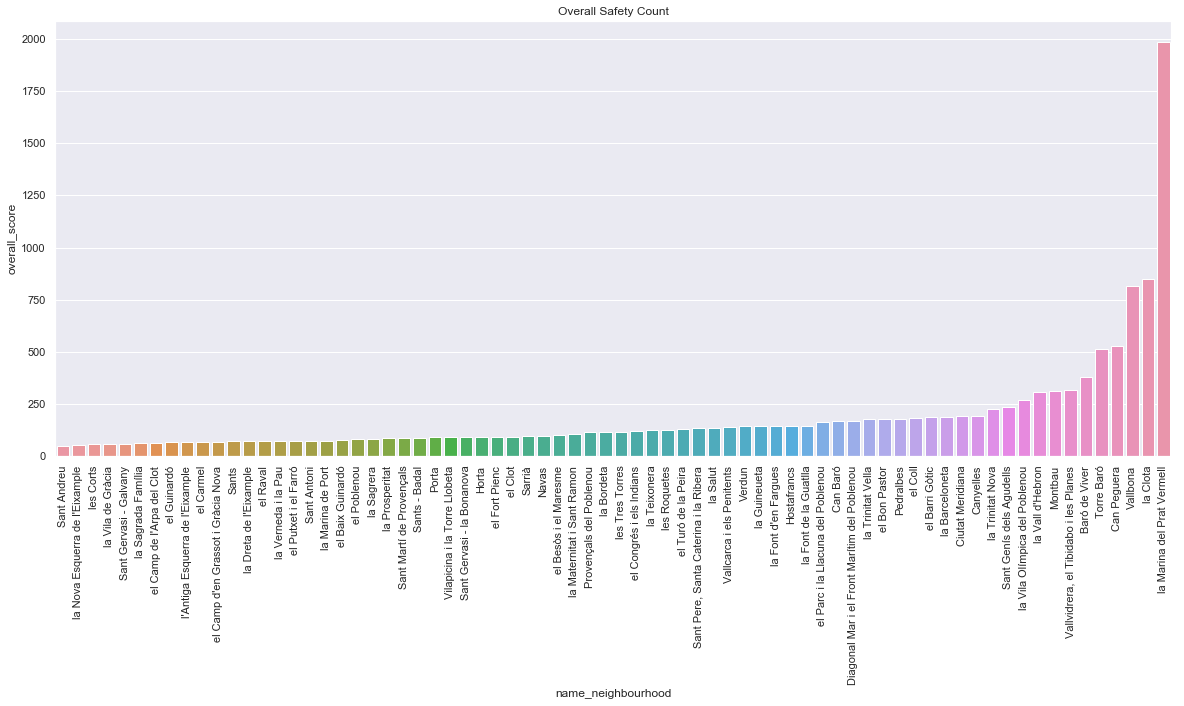

In [311]:
# A graph will help use visualize diffrences in criminality rates per neighborhood
fig,ax = plt.subplots(figsize=(20,8))
ax.set(xlabel='name_neighbourhood', ylabel='count')
ax.set_title("Overall Safety Count")
sns.barplot(ax = ax, x = 'name_neighbourhood', y = 'overall_score', 
            data = merged_df.sort_values(by='overall_score',ascending=True)
            .dropna())
plt.xticks(rotation=90)
plt.savefig("overall_safety_barrios.jpg",frameon=True);